# Neural Machine Translation

* We will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25"). 
* We will do this using an attention model, one of the most sophisticated sequence-to-sequence models. 

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Faker is a Python package that generates fake data. Whether we need to bootstrap our database, create good-looking XML documents, fill-in our persistence to stress test it, or anonymize data taken from a production service, Faker is for us.

## 1 - Translating human readable dates into machine readable dates

* The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. 
* However, language translation requires massive datasets and usually takes days of training on GPUs. 
* To give you a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task. 
* The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) 
* The network will translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). 
* We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates.

In [2]:
# Dataset

m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 19067.98it/s]


In [3]:
dataset[:10]

[('wednesday march 20 1996', '1996-03-20'),
 ('8/15/98', '1998-08-15'),
 ('03.10.72', '1972-10-03'),
 ('august 15 1987', '1987-08-15'),
 ('oct 16 2004', '2004-10-16'),
 ('25 jan 2003', '2003-01-25'),
 ('jul 22 1997', '1997-07-22'),
 ('22.08.90', '1990-08-22'),
 ('friday june 7 2002', '2002-06-07'),
 ('saturday may 14 1994', '1994-05-14')]

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30 
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: wednesday march 20 1996
Target date: 1996-03-20

Source after preprocessing (indices): [33 17 16 25 17 29 16 13 34  0 24 13 28 15 20  0  5  3  0  4 12 12  9 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  7  0  1  4  0  3  1]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Attention mechanism

### Implementation Details
   
Let's implement this neural translator. We will start by implementing two functions: `one_step_attention()` and `model()`.

In [6]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [7]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    
    return context

In [8]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# This is the post attention LSTM cell.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense(len(machine_vocab), activation=softmax)

In [9]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(units= n_a, return_sequences= True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(inputs= context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(inputs= s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs= outputs)
    
    return model

In [10]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          

In [12]:
### Optimizer 
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### Define inputs and outputs, and fit the model
The last step is to define all your inputs and outputs to fit the model:
- We have input X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- We need to create `s0` and `c0` to initialize your `post_attention_LSTM_cell` with zeros.
- Given the `model()` we coded, we need the "outputs" to be a list of 10 elements of shape (m, T_y). 
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). 
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [13]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [14]:
# Training

model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1


 2800/10000 [=======>......................] - ETA: 25:14 - loss: 24.0220 - dense_3_loss: 2.3955 - dense_3_acc: 0.0400 - dense_3_acc_1: 0.5200 - dense_3_acc_2: 0.1600 - dense_3_acc_3: 0.0800 - dense_3_acc_4: 0.0000e+00 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0300 - dense_3_acc_7: 0.0000e+00 - dense_3_acc_8: 0.0500 - dense_3_acc_9: 0.11 - ETA: 12:38 - loss: 23.8352 - dense_3_loss: 2.4031 - dense_3_acc: 0.0200 - dense_3_acc_1: 0.2950 - dense_3_acc_2: 0.0850 - dense_3_acc_3: 0.0400 - dense_3_acc_4: 0.4950 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0150 - dense_3_acc_7: 0.4950 - dense_3_acc_8: 0.0250 - dense_3_acc_9: 0.0550       - ETA: 8:26 - loss: 23.6135 - dense_3_loss: 2.4178 - dense_3_acc: 0.0133 - dense_3_acc_1: 0.1967 - dense_3_acc_2: 0.0567 - dense_3_acc_3: 0.0267 - dense_3_acc_4: 0.6633 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0100 - dense_3_acc_7: 0.6633 - dense_3_acc_8: 0.0167 - dense_3_acc_9: 0.0367 - ETA: 6:19 - loss: 23.3680 - dense_3_loss: 2.4489 - dense_3_a

 5600/10000 [===============>..............] - ETA: 49s - loss: 21.0959 - dense_3_loss: 2.7892 - dense_3_acc: 0.0014 - dense_3_acc_1: 0.3866 - dense_3_acc_2: 0.1366 - dense_3_acc_3: 0.0452 - dense_3_acc_4: 0.9634 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0010 - dense_3_acc_7: 0.9576 - dense_3_acc_8: 0.0386 - dense_3_acc_9: 0.02 - ETA: 47s - loss: 21.0381 - dense_3_loss: 2.7877 - dense_3_acc: 0.0013 - dense_3_acc_1: 0.3923 - dense_3_acc_2: 0.1383 - dense_3_acc_3: 0.0437 - dense_3_acc_4: 0.9647 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 1.0000e-03 - dense_3_acc_7: 0.9590 - dense_3_acc_8: 0.0373 - dense_3_acc_9: 0.02 - ETA: 45s - loss: 20.9802 - dense_3_loss: 2.7884 - dense_3_acc: 0.0148 - dense_3_acc_1: 0.3997 - dense_3_acc_2: 0.1416 - dense_3_acc_3: 0.0468 - dense_3_acc_4: 0.9658 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 9.6774e-04 - dense_3_acc_7: 0.9603 - dense_3_acc_8: 0.0361 - dense_3_acc_9: 0.02 - ETA: 43s - loss: 20.9217 - dense_3_loss: 2.7873 - dense_3_acc: 0.0337 - den

 8500/10000 [========================>.....] - ETA: 18s - loss: 19.6694 - dense_3_loss: 2.7659 - dense_3_acc: 0.2789 - dense_3_acc_1: 0.4882 - dense_3_acc_2: 0.1995 - dense_3_acc_3: 0.0467 - dense_3_acc_4: 0.9814 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 5.2632e-04 - dense_3_acc_7: 0.9767 - dense_3_acc_8: 0.1067 - dense_3_acc_9: 0.07 - ETA: 18s - loss: 19.6235 - dense_3_loss: 2.7628 - dense_3_acc: 0.2843 - dense_3_acc_1: 0.4900 - dense_3_acc_2: 0.2012 - dense_3_acc_3: 0.0466 - dense_3_acc_4: 0.9817 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 5.1724e-04 - dense_3_acc_7: 0.9771 - dense_3_acc_8: 0.1100 - dense_3_acc_9: 0.07 - ETA: 17s - loss: 19.5748 - dense_3_loss: 2.7598 - dense_3_acc: 0.2900 - dense_3_acc_1: 0.4927 - dense_3_acc_2: 0.2037 - dense_3_acc_3: 0.0463 - dense_3_acc_4: 0.9820 - dense_3_acc_5: 0.0025 - dense_3_acc_6: 5.0847e-04 - dense_3_acc_7: 0.9710 - dense_3_acc_8: 0.1151 - dense_3_acc_9: 0.0744   - ETA: 17s - loss: 19.5256 - dense_3_loss: 2.7588 - dense_3_acc: 0.2965 -

10000/10000 [==============================] - ETA: 4s - loss: 17.7719 - dense_3_loss: 2.6729 - dense_3_acc: 0.3930 - dense_3_acc_1: 0.5857 - dense_3_acc_2: 0.2558 - dense_3_acc_3: 0.0573 - dense_3_acc_4: 0.9877 - dense_3_acc_5: 0.1949 - dense_3_acc_6: 0.0267 - dense_3_acc_7: 0.9799 - dense_3_acc_8: 0.1958 - dense_3_acc_9: 0.094 - ETA: 4s - loss: 17.7022 - dense_3_loss: 2.6690 - dense_3_acc: 0.3977 - dense_3_acc_1: 0.5893 - dense_3_acc_2: 0.2567 - dense_3_acc_3: 0.0583 - dense_3_acc_4: 0.9878 - dense_3_acc_5: 0.2020 - dense_3_acc_6: 0.0282 - dense_3_acc_7: 0.9801 - dense_3_acc_8: 0.1985 - dense_3_acc_9: 0.094 - ETA: 4s - loss: 17.6331 - dense_3_loss: 2.6650 - dense_3_acc: 0.4012 - dense_3_acc_1: 0.5931 - dense_3_acc_2: 0.2584 - dense_3_acc_3: 0.0591 - dense_3_acc_4: 0.9880 - dense_3_acc_5: 0.2081 - dense_3_acc_6: 0.0299 - dense_3_acc_7: 0.9803 - dense_3_acc_8: 0.1999 - dense_3_acc_9: 0.094 - ETA: 3s - loss: 17.5642 - dense_3_loss: 2.6609 - dense_3_acc: 0.4062 - dense_3_acc_1: 0.5960 - 

We have run this model for longer, and saved the weights. Load the weights.

In [15]:
model.load_weights('models/model.h5')

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          

In [17]:
# Result

# EXAMPLES = ['3 July 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
# for example in EXAMPLES:
    
#     source = string_to_int(example, Tx, human_vocab)
#     source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
#     prediction = model.predict([source, s0, c0])
#     prediction = np.argmax(prediction, axis = -1)
#     output = [inv_machine_vocab[int(i)] for i in prediction]
    
#     print("source:", example)
#     print("output:", ''.join(output),"\n")

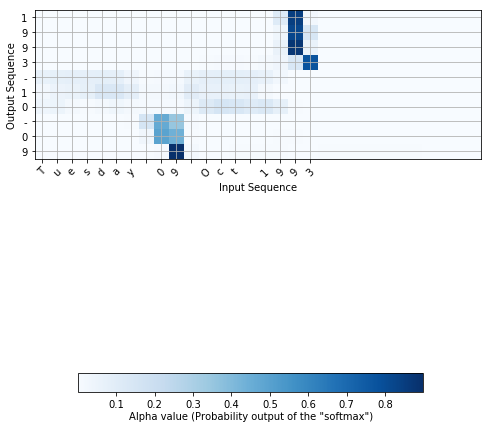

In [18]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);